<a href="https://colab.research.google.com/github/miniact/mangyaWAF/blob/master/mms_waf_feature_Engineering~mangesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


This is the main notebook performing all feature engineering
The different steps are:

Step1 - import dependencies

Step2 - load payloads into memory

Step3A - Feature engineering custom features


# Step 1 : import dependencies



In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn
import string
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve
from sklearn.decomposition import TruncatedSVD

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# step 2: load data set


In [ ]:
payloads = pd.read_csv("https://trello-attachments.s3.amazonaws.com/5ed2d4107c349c221194b608/5ed2d453f0e5a45bcd8cf16c/4265dd7f345df26845ccc5b7f82a7289/payloads.csv",index_col="index")
payloads.head(30)

,payload,is_malicious,injection_type
index,,,
0,37662577P,0.0,LEGAL
1,shirting,0.0,LEGAL
2,&kw=%27;alert%28%27XSS%27%29;//,1.0,XSS
3,obeying,0.0,LEGAL
4,dictating,0.0,LEGAL
5,lafleur,0.0,LEGAL
6,capturers,0.0,LEGAL
7,8nca58z48,0.0,LEGAL
8,autocratic,0.0,LEGAL


#Step3A - Feature engineering custom features
*  length of payload
*  number of non-printable characters in payload
*  number of punctuation characters in payload
*  the minimum byte value of payload
*  the maximum byte value of payload
*  the mean byte value of payload
*  the standard deviation of payload byte values
*  number of distinct bytes in payload
*  number of SQL keywords in payload
*  number of javascript keywords in payload

In [ ]:
def plot_feature_distribution(features):

  """ 
  function to quickly genetrate graph  and describe about feature
  """
  print('Properties of feature: ' + features.name)
  print(features.describe())
  f, ax = plt.subplots(1, figsize=(10, 6))
  ax.hist(features, bins=features.max()-features.min()+1, normed=1)
  ax.set_xlabel('value')
  ax.set_ylabel('fraction')
    
  plt.show()

,payload,is_malicious,injection_type,length
index,,,,
0,37662577P,0.0,LEGAL,9
1,shirting,0.0,LEGAL,8
2,&kw=%27;alert%28%27XSS%27%29;//,1.0,XSS,31
3,obeying,0.0,LEGAL,7
4,dictating,0.0,LEGAL,9


Properties of feature: length
count    110357.000000
mean         16.559629
std          32.108640
min           1.000000
25%           6.000000
50%           9.000000
75%          14.000000
max         974.000000
Name: length, dtype: float64


AttributeError: ignored

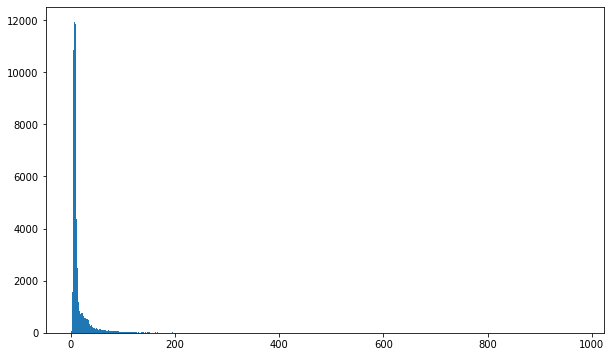

In [ ]:
def create_feature_length(payloads):
  """
  function to create length feature
  """
  payloads['length'] = [len(str(row)) for row in payloads['payload'] ]
  return payloads

payloads = create_feature_length(payloads)
display(payloads.head())
#plot graph
plot_feature_distribution(payloads['length'])

,payload,is_malicious,injection_type,length,non-printable
index,,,,,
0,37662577P,0.0,LEGAL,9,0
1,shirting,0.0,LEGAL,8,0
2,&kw=%27;alert%28%27XSS%27%29;//,1.0,XSS,31,0
3,obeying,0.0,LEGAL,7,0
4,dictating,0.0,LEGAL,9,0


Properties of feature: non-printable
count    110357.000000
mean          0.007412
std           0.216736
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          30.000000
Name: non-printable, dtype: float64


AttributeError: ignored

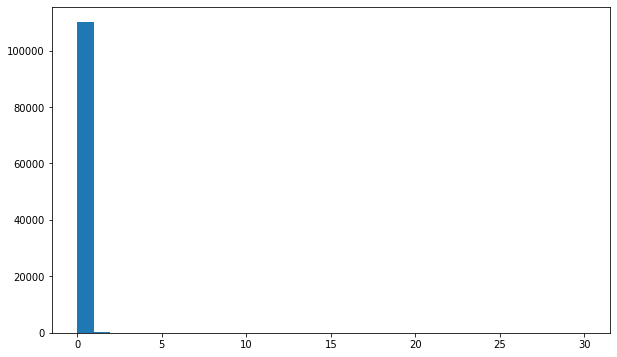

In [ ]:
def create_feature_nonprintable(payloads):
  """ 
   function to find non- printable char in payload if present -->1 if absent --> 0
  """
  payloads['non-printable'] = [len([1 for letter in str(row) if letter not in string.printable]) for row in payloads['payload']]
  return payloads

payloads = create_feature_nonprintable(payloads)
display(payloads.head())

plot_feature_distribution(payloads['non-printable'])


,payload,is_malicious,injection_type,length,non-printable,punctuation
index,,,,,,
0,37662577P,0.0,LEGAL,9,0,0
1,shirting,0.0,LEGAL,8,0,0
2,&kw=%27;alert%28%27XSS%27%29;//,1.0,XSS,31,0,11
3,obeying,0.0,LEGAL,7,0,0
4,dictating,0.0,LEGAL,9,0,0


Properties of feature: punctuation
count    110357.000000
mean          2.363729
std           9.771260
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         538.000000
Name: punctuation, dtype: float64


AttributeError: ignored

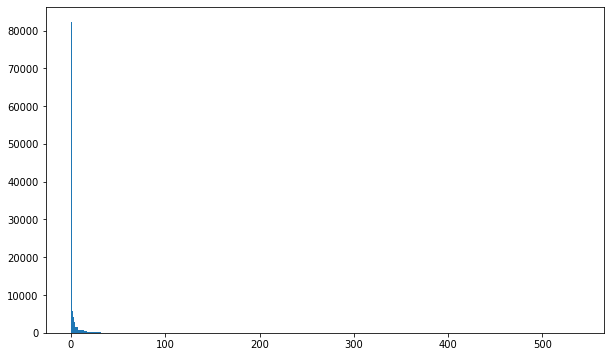

In [ ]:
def create_feature_punchualchar(payloads):
  #adds new punctual cloumns with count of punctual characters in payload
  payloads['punctuation'] = [len([1 for letter in str(row) if letter in string.punctuation])  for row in payloads['payload']]
  return payloads

payloads = create_feature_punchualchar(payloads)
display(payloads.head())

plot_feature_distribution(payloads['punctuation'])

,payload,is_malicious,injection_type,length,non-printable,punctuation,min-byte
index,,,,,,,
0,37662577P,0.0,LEGAL,9,0,0,50
1,shirting,0.0,LEGAL,8,0,0,103
2,&kw=%27;alert%28%27XSS%27%29;//,1.0,XSS,31,0,11,37
3,obeying,0.0,LEGAL,7,0,0,98
4,dictating,0.0,LEGAL,9,0,0,97


Properties of feature: min-byte
count    110357.000000
mean         71.225749
std          26.545783
min           9.000000
25%          48.000000
50%          75.000000
75%          97.000000
max         125.000000
Name: min-byte, dtype: float64


AttributeError: ignored

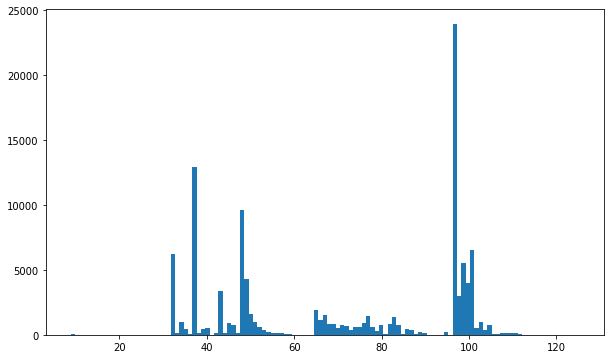

In [ ]:
# minimum byte value of payload
def create_feature_minbyte(payloads):
  payloads['min-byte'] = [min(bytearray(str(row),'utf-8')) for row in payloads['payload']]
  return payloads

payloads = create_feature_minbyte(payloads)
display(payloads.head())
plot_feature_distribution(payloads['min-byte'])  


,payload,is_malicious,injection_type,length,non-printable,punctuation,min-byte,max-byte
index,,,,,,,,
0,37662577P,0.0,LEGAL,9,0,0,50,80
1,shirting,0.0,LEGAL,8,0,0,103,116
2,&kw=%27;alert%28%27XSS%27%29;//,1.0,XSS,31,0,11,37,119
3,obeying,0.0,LEGAL,7,0,0,98,121
4,dictating,0.0,LEGAL,9,0,0,97,116


Properties of feature: max-byte
count    110357.000000
mean        109.495166
std          20.327684
min          33.000000
25%         114.000000
50%         116.000000
75%         118.000000
max         240.000000
Name: max-byte, dtype: float64


AttributeError: ignored

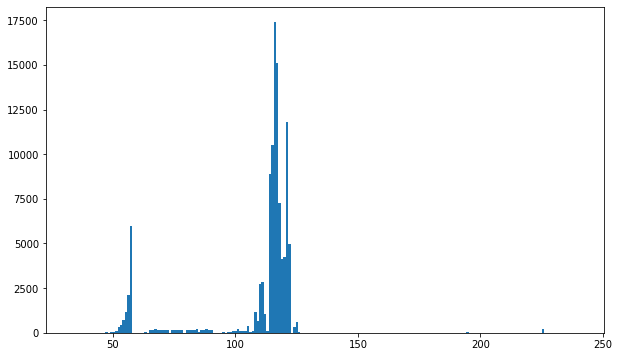

In [ ]:
#max byte feature# maximum byte value of payload
def create_feature_minbyte(payloads):
  payloads['max-byte'] = [max(bytearray(str(row),'utf-8')) for row in payloads['payload']]
  return payloads

payloads = create_feature_minbyte(payloads)
display(payloads.head())
plot_feature_distribution(payloads['max-byte'])  


,payload,is_malicious,injection_type,length,non-printable,punctuation,min-byte,max-byte,mean-byte
index,,,,,,,,,
0,37662577P,0.0,LEGAL,9,0,0,50,80,56.333333
1,shirting,0.0,LEGAL,8,0,0,103,116,109.000000
2,&kw=%27;alert%28%27XSS%27%29;//,1.0,XSS,31,0,11,37,119,65.806452
3,obeying,0.0,LEGAL,7,0,0,98,121,107.000000
4,dictating,0.0,LEGAL,9,0,0,97,116,105.666667


Properties of feature: mean-byte
count    110357.000000
mean         92.514041
std          19.323046
min          33.000000
25%          83.000000
50%         101.000000
75%         107.000000
max         164.000000
Name: mean-byte, dtype: float64


AttributeError: ignored

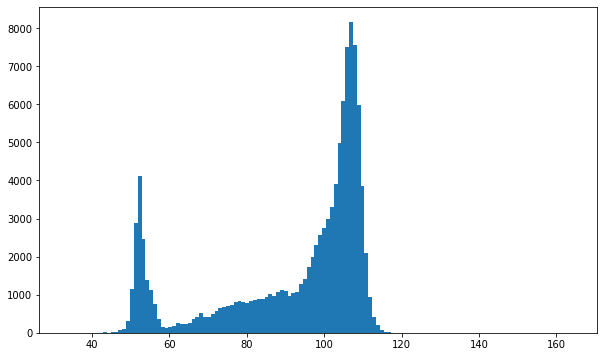

In [ ]:
#mean byte value of payload
def create_feature_minbyte(payloads):
  payloads['mean-byte'] = [np.mean(bytearray(str(row),'utf-8')) for row in payloads['payload']]
  return payloads

payloads = create_feature_minbyte(payloads)
display(payloads.head())
plot_feature_distribution(payloads['mean-byte'].astype(int))


,payload,is_malicious,injection_type,length,non-printable,punctuation,min-byte,max-byte,mean-byte,std-byte
index,,,,,,,,,,
0,37662577P,0.0,LEGAL,9,0,0,50,80,56.333333,8.537499
1,shirting,0.0,LEGAL,8,0,0,103,116,109.000000,5.049752
2,&kw=%27;alert%28%27XSS%27%29;//,1.0,XSS,31,0,11,37,119,65.806452,26.617263
3,obeying,0.0,LEGAL,7,0,0,98,121,107.000000,7.151423
4,dictating,0.0,LEGAL,9,0,0,97,116,105.666667,6.599663


Properties of feature: std-byte
count    110357.000000
mean         12.155677
std           9.201188
min           0.000000
25%           5.000000
50%           7.000000
75%          20.000000
max          75.000000
Name: std-byte, dtype: float64


AttributeError: ignored

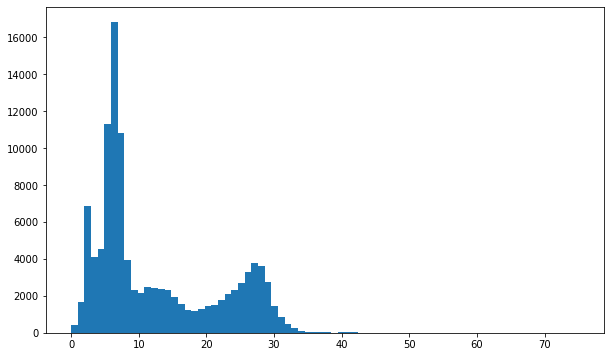

In [ ]:
#standard deviation of byte value of payload
def create_feature_minbyte(payloads):
  payloads['std-byte'] = [np.std(bytearray(str(row),'utf-8')) for row in payloads['payload']]
  return payloads

payloads = create_feature_minbyte(payloads)
display(payloads.head())
plot_feature_distribution(payloads['std-byte'].astype(int))


,payload,is_malicious,injection_type,length,non-printable,punctuation,min-byte,max-byte,mean-byte,std-byte,distinct-byte
index,,,,,,,,,,,
0,37662577P,0.0,LEGAL,9,0,0,50,80,56.333333,8.537499,6
1,shirting,0.0,LEGAL,8,0,0,103,116,109.000000,5.049752,7
2,&kw=%27;alert%28%27XSS%27%29;//,1.0,XSS,31,0,11,37,119,65.806452,26.617263,18
3,obeying,0.0,LEGAL,7,0,0,98,121,107.000000,7.151423,7
4,dictating,0.0,LEGAL,9,0,0,97,116,105.666667,6.599663,7


Properties of feature: distinct-byte
count    110357.000000
mean          9.483078
std           7.410805
min           1.000000
25%           5.000000
50%           7.000000
75%          10.000000
max          76.000000
Name: distinct-byte, dtype: float64


AttributeError: ignored

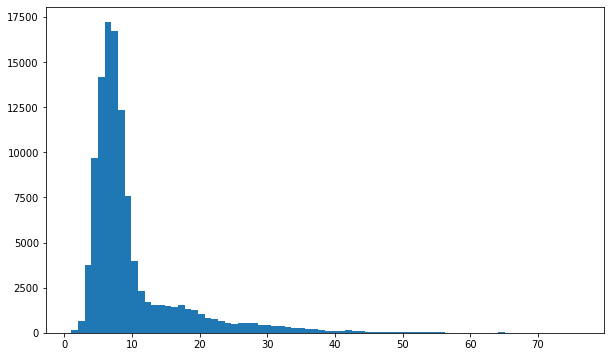

In [ ]:
#distinct byte value of payload
def create_feature_minbyte(payloads):
  payloads['distinct-byte'] = [len(set(bytearray(str(row),'utf-8'))) for row in payloads['payload']]
  return payloads

payloads = create_feature_minbyte(payloads)
display(payloads.head())
plot_feature_distribution(payloads['distinct-byte'].astype(int))


pandas.core.frame.DataFrame

,payload,is_malicious,injection_type,length,non-printable,punctuation,min-byte,max-byte,mean-byte,std-byte,distinct-byte,sql-keywords
index,,,,,,,,,,,,
0,37662577P,0.0,LEGAL,9,0,0,50,80,56.333333,8.537499,6,0
1,shirting,0.0,LEGAL,8,0,0,103,116,109.000000,5.049752,7,0
2,&kw=%27;alert%28%27XSS%27%29;//,1.0,XSS,31,0,11,37,119,65.806452,26.617263,18,0
3,obeying,0.0,LEGAL,7,0,0,98,121,107.000000,7.151423,7,0
4,dictating,0.0,LEGAL,9,0,0,97,116,105.666667,6.599663,7,0


Properties of feature: sql-keywords
count    110357.000000
mean          0.196009
std           0.671691
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          15.000000
Name: sql-keywords, dtype: float64


AttributeError: ignored

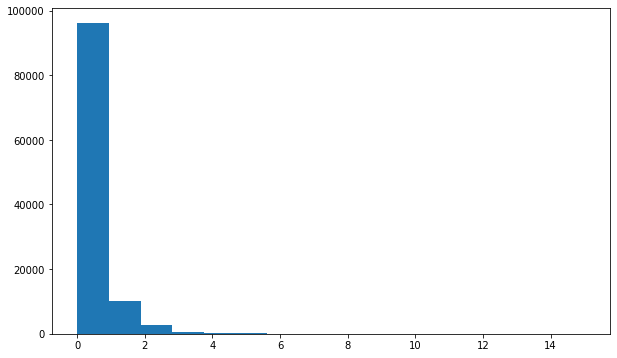

In [ ]:
#number of SQL keywords in payload
sql_keywords = pd.read_csv('https://trello-attachments.s3.amazonaws.com/5ed2d4107c349c221194b608/5ed2d453f0e5a45bcd8cf16c/435e639346787ce2b495a16e9f690ef5/SQLKeywords.txt', index_col=False)

def create_feature_sql_keywords(payloads):
    
    '''
    Feature
    Number of SQL keywords within payload
    '''
    payloads['sql-keywords'] = [ len([1 for keyword in sql_keywords['Keyword'] if str(keyword).lower() in str(row).lower()]) for row in payloads['payload']]
    return payloads

create_feature_sql_keywords(payloads)
display(type(sql_keywords))
display(payloads.head())
plot_feature_distribution(payloads['sql-keywords'])

,Keyword
0,abstract
1,arguments
2,await*
3,boolean
4,break
...,...
143,textarea
144,top
145,unescape
146,untaint


,payload,is_malicious,injection_type,length,non-printable,punctuation,min-byte,max-byte,mean-byte,std-byte,distinct-byte,sql-keywords,js-keywords
index,,,,,,,,,,,,,
0,37662577P,0.0,LEGAL,9,0,0,50,80,56.333333,8.537499,6,0,0
1,shirting,0.0,LEGAL,8,0,0,103,116,109.000000,5.049752,7,0,1
2,&kw=%27;alert%28%27XSS%27%29;//,1.0,XSS,31,0,11,37,119,65.806452,26.617263,18,0,1
3,obeying,0.0,LEGAL,7,0,0,98,121,107.000000,7.151423,7,0,1
4,dictating,0.0,LEGAL,9,0,0,97,116,105.666667,6.599663,7,0,1


Properties of feature: js-keywords
count    110357.000000
mean          0.354857
std           0.821220
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          15.000000
Name: js-keywords, dtype: float64


AttributeError: ignored

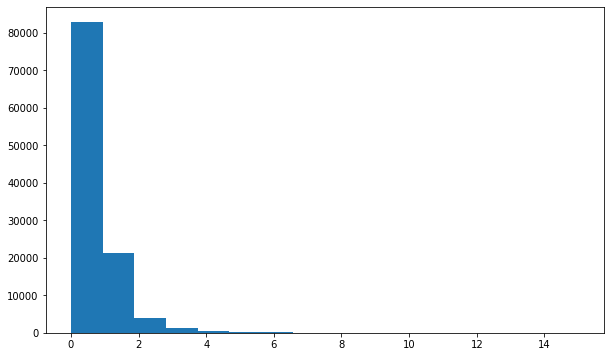

In [ ]:
# javascript key word is presten or not in payload
js_keywords = pd.read_csv("https://trello-attachments.s3.amazonaws.com/5ed2d4107c349c221194b608/5ed2d453f0e5a45bcd8cf16c/dedc7eb9846a30c252cd950a0e2153d9/JavascriptKeywords.txt",index_col=False)
def create_feature_javascript_keywords(payloads):
  payloads['js-keywords'] = [len([1 for keyword in js_keywords['Keyword'] if str(keyword).lower() in str(row).lower()]) for row in payloads['payload']]
  return payloads
display(js_keywords)
payloads = create_feature_javascript_keywords(payloads)
display(payloads.head())
plot_feature_distribution(payloads['js-keywords'])

**Store all data in csv file for modeling**

In [ ]:
payloads.to_csv("final-allpayload.csv",encoding='UTF-8')


**-->Testing For correlations between the dependent and independent variable**

In [ ]:
payloads.corr()

,is_malicious,length,non-printable,punctuation,min-byte,max-byte,mean-byte,std-byte,distinct-byte,sql-keywords,js-keywords
is_malicious,1.000000,0.503527,0.109038,0.545746,-0.437840,0.169479,-0.194447,0.523487,0.672833,0.362440,0.484594
length,0.503527,1.000000,0.054125,0.822890,-0.371302,0.120582,-0.171218,0.400627,0.764464,0.515105,0.548591
non-printable,0.109038,0.054125,1.000000,0.051506,-0.045852,0.184621,0.023385,0.120833,0.089188,0.016287,0.036184
punctuation,0.545746,0.822890,0.051506,1.000000,-0.328024,0.102129,-0.173458,0.363667,0.596996,0.374709,0.440164
min-byte,-0.437840,-0.371302,-0.045852,-0.328024,1.000000,0.276576,0.731282,-0.716344,-0.560139,-0.194122,-0.204792
max-byte,0.169479,0.120582,0.184621,0.102129,0.276576,1.000000,0.770179,0.432612,0.261911,0.134943,0.203148
mean-byte,-0.194447,-0.171218,0.023385,-0.173458,0.731282,0.770179,1.000000,-0.143514,-0.172886,-0.030739,0.027468
std-byte,0.523487,0.400627,0.120833,0.363667,-0.716344,0.432612,-0.143514,1.000000,0.669620,0.265067,0.312151
distinct-byte,0.672833,0.764464,0.089188,0.596996,-0.560139,0.261911,-0.172886,0.669620,1.000000,0.497401,0.583256
sql-keywords,0.362440,0.515105,0.016287,0.374709,-0.194122,0.134943,-0.030739,0.265067,0.497401,1.000000,0.557342


***Function to Apply all custom feature engineering and gives a final dataset***

In [ ]:
def create_features(payloads):
    features = create_feature_length(payloads)
    features = create_feature_non_printable_characters(features)
    features = create_feature_punctuation_characters(features)
    features = create_feature_max_byte_value(features)
    features = create_feature_min_byte_value(features)
    features = create_feature_mean_byte_value(features)
    features = create_feature_std_byte_value(features)
    features = create_feature_distinct_bytes(features)
    features = create_feature_sql_keywords(features)
    features = create_feature_javascript_keywords(features)
    del features['payload']

    return features